# We are going to predict the financial loss category (by 6 categories) of a cybersecurity attack, using different models. Our goal is to compare these different models, and see which one is the best in our case.

In [16]:
# Imports

import pandas as pd
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np
import matplotlib.pyplot as plt
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, classification_report
from sklearn.ensemble import StackingClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report
from sklearn.model_selection import GridSearchCV
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split


In [17]:
# csv opening
df = pd.read_csv("Global_Cybersecurity_Threats_2015-2024.csv")

df.head()

,Country,Year,Attack Type,Target Industry,Financial Loss (in Million $),Number of Affected Users,Attack Source,Security Vulnerability Type,Defense Mechanism Used,Incident Resolution Time (in Hours)
0,China,2019,Phishing,Education,80.53,773169,Hacker Group,Unpatched Software,VPN,63
1,China,2019,Ransomware,Retail,62.19,295961,Hacker Group,Unpatched Software,Firewall,71
2,India,2017,Man-in-the-Middle,IT,38.65,605895,Hacker Group,Weak Passwords,VPN,20
3,UK,2024,Ransomware,Telecommunications,41.44,659320,Nation-state,Social Engineering,AI-based Detection,7
4,Germany,2018,Man-in-the-Middle,IT,74.41,810682,Insider,Social Engineering,VPN,68


General informations
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3000 entries, 0 to 2999
Data columns (total 10 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   Country                              3000 non-null   object 
 1   Year                                 3000 non-null   int64  
 2   Attack Type                          3000 non-null   object 
 3   Target Industry                      3000 non-null   object 
 4   Financial Loss (in Million $)        3000 non-null   float64
 5   Number of Affected Users             3000 non-null   int64  
 6   Attack Source                        3000 non-null   object 
 7   Security Vulnerability Type          3000 non-null   object 
 8   Defense Mechanism Used               3000 non-null   object 
 9   Incident Resolution Time (in Hours)  3000 non-null   int64  
dtypes: float64(1), int64(3), object(6)
memory usage: 234.5+ KB
None 

Descripti

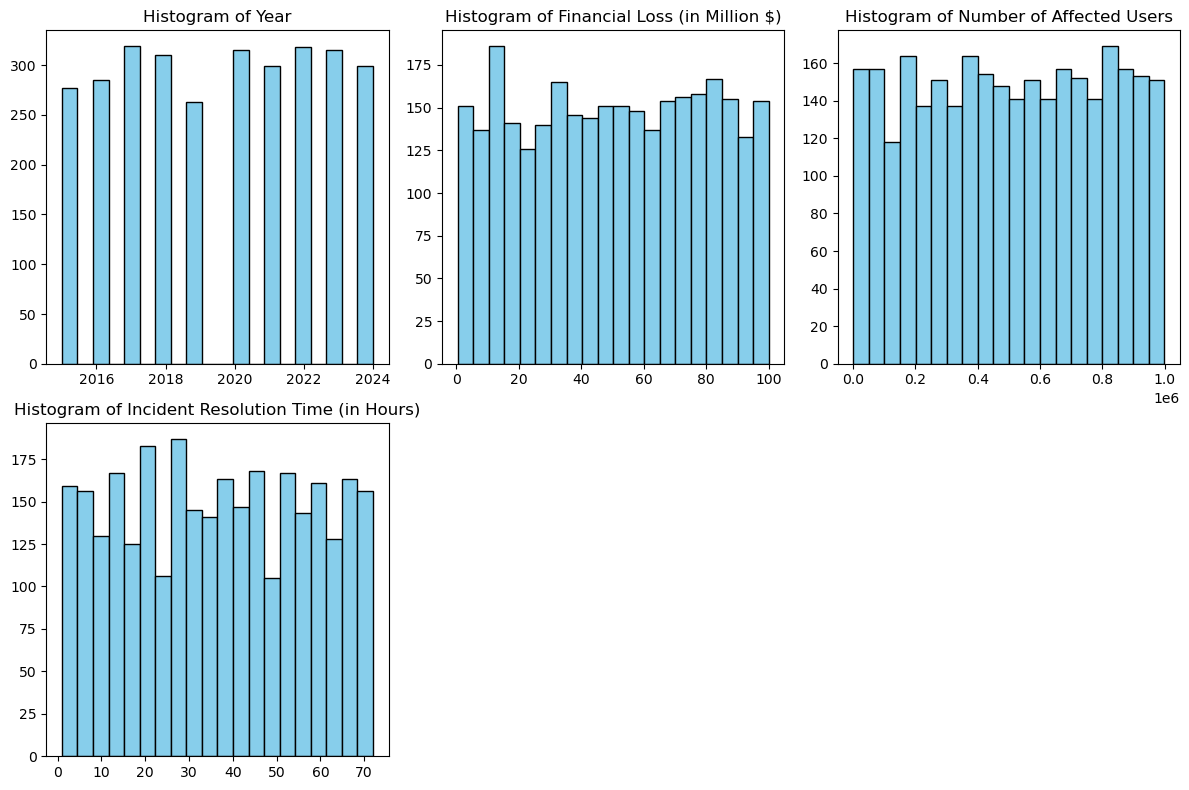

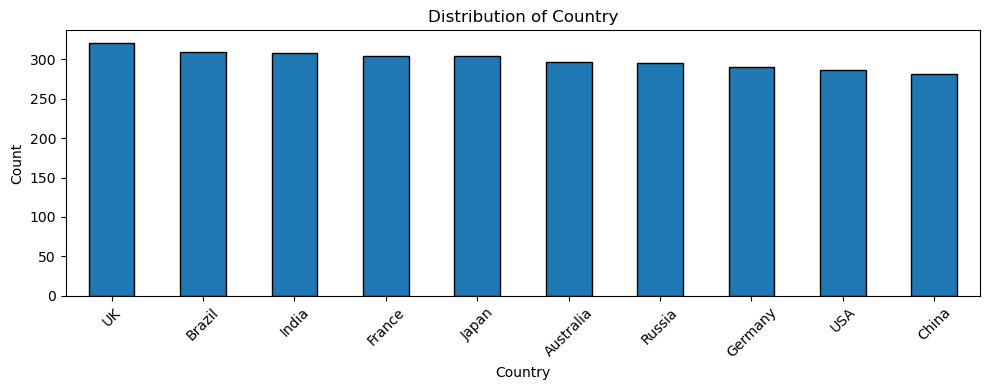

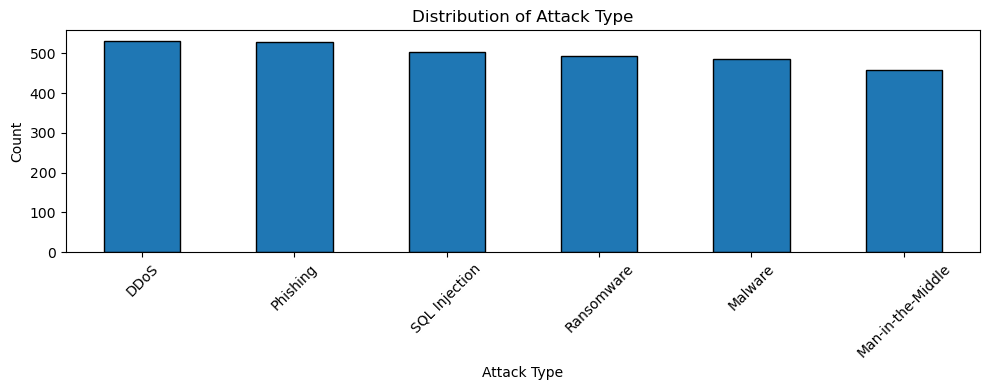

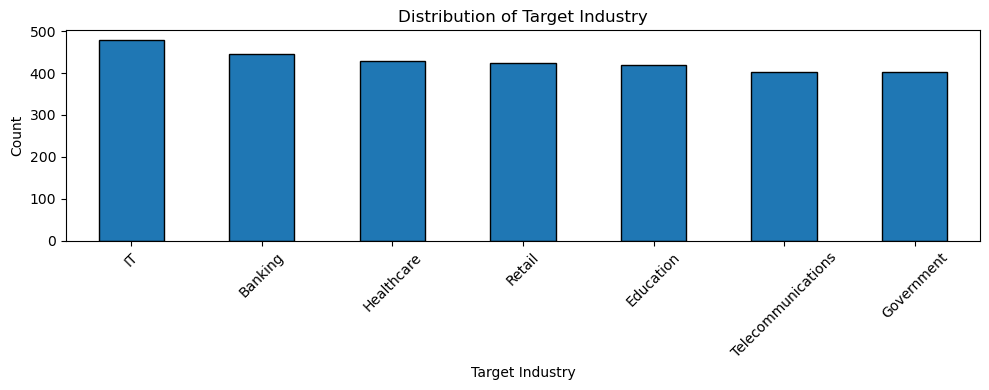

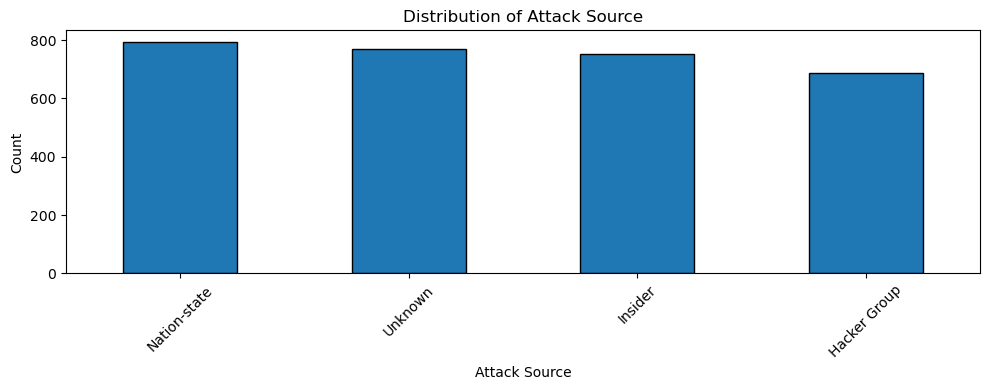

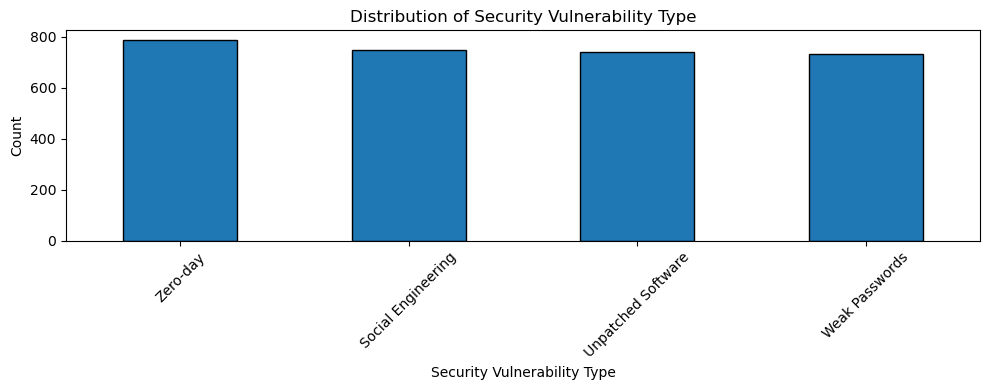

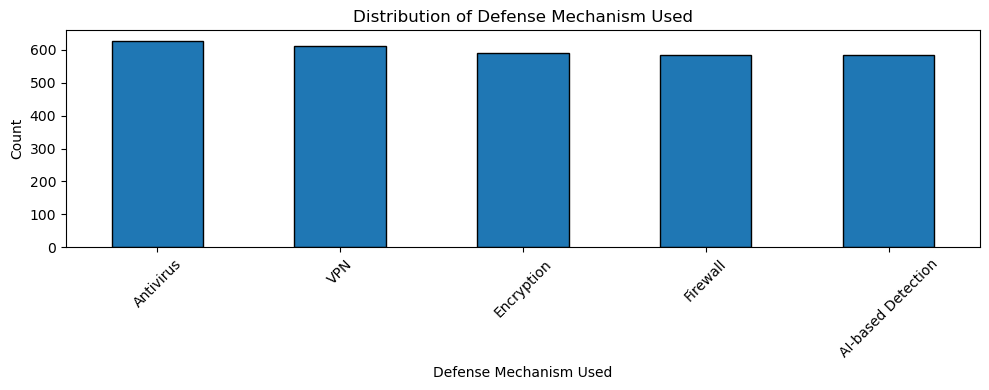

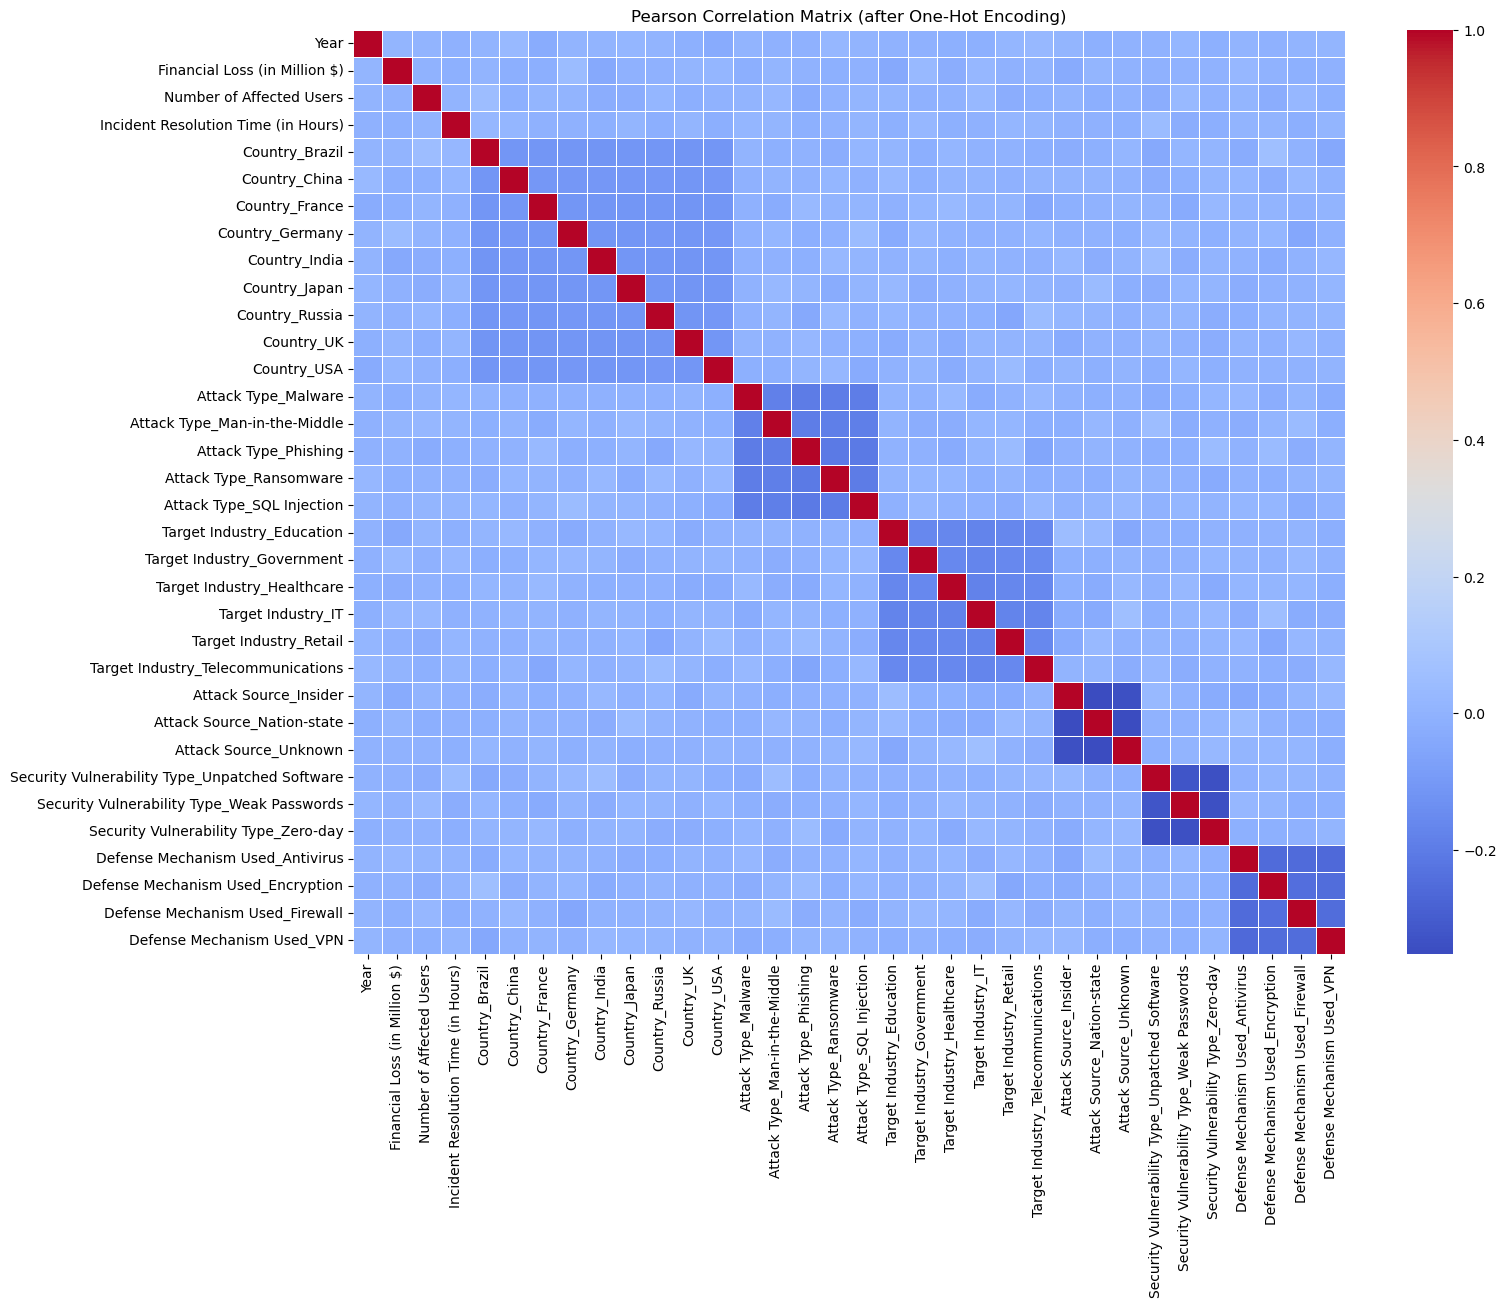

In [18]:
print("General informations")
print(df.info(), "\n")

print("Descriptive statistics")
print(df.describe(include='all'), "\n")

# Histogram of quantitative columns
num_cols = df.select_dtypes(include=[np.number]).columns
plt.figure(figsize=(12, 8))
for i, col in enumerate(num_cols):
    plt.subplot(2, 3, i + 1)
    plt.hist(df[col], bins=20, color='skyblue', edgecolor='black')
    plt.title(f"Histogram of {col}")
    plt.tight_layout()

plt.show()

# General distribution statistics
categorical_cols = df.select_dtypes(include=['object']).columns
for col in categorical_cols:
    plt.figure(figsize=(10, 4))
    df[col].value_counts().plot(kind='bar', edgecolor='black')
    plt.title(f"Distribution of {col}")
    plt.xlabel(col)
    plt.ylabel("Count")
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

# Correlation matrix (mixing quantitative and qualitative values)
df_corr = df.copy()

# Select categorical columns
cat_cols = df_corr.select_dtypes(include=['object']).columns

# One-hot encode categorical variables
df_corr_encoded = pd.get_dummies(df_corr, columns=cat_cols, drop_first=True)

# Compute correlation
corr_matrix = df_corr_encoded.corr()

plt.figure(figsize=(16, 12))
sns.heatmap(corr_matrix, cmap="coolwarm", linewidths=0.5)
plt.title("Pearson Correlation Matrix (after One-Hot Encoding)")
plt.show()

Pearson's correlation matrix clearly show that there's clearly no correlation betwin our variables
However, we are still going to process with it.

In [20]:
# Data pre-processing

# Missing values checking
print("Missing values per column:")
print(df.isna().sum(), "\n")

# Duplicate values checking
duplicate_count = df.duplicated().sum()
print("Number of duplicate rows:", duplicate_count)

# Outliers checking
num_cols = df.select_dtypes(include=[np.number]).columns
for col in num_cols:
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1
    lower = Q1 - 1.5 * IQR
    upper = Q3 + 1.5 * IQR
    outliers = df[(df[col] < lower) | (df[col] > upper)].shape[0]
    print(f"Outliers in {col}: {outliers}")
    
# Variable that we want to predict
target = "Financial Loss (in Million $)"
y = df[target]

# Remove target + remove raw loss column and also financial loss (since it is related to target)
X = df.drop(columns=[target])


# ColumnTransformer: numeric are scalind, categorical are one-hoted
cat_cols = X.select_dtypes(include=["object"]).columns.tolist()
num_cols = X.select_dtypes(exclude=["object"]).columns.tolist()

preprocessor = ColumnTransformer(
    transformers=[
        ("num", StandardScaler(), num_cols),
        ("cat", OneHotEncoder(handle_unknown="ignore"), cat_cols)
    ]
)


# 80% training, 20% testing
X_train, X_test, y_train, y_test = train_test_split(
    X, 
    y, 
    test_size=0.2,    
    random_state=42
)

Missing values per column:
Country                                0
Year                                   0
Attack Type                            0
Target Industry                        0
Financial Loss (in Million $)          0
Number of Affected Users               0
Attack Source                          0
Security Vulnerability Type            0
Defense Mechanism Used                 0
Incident Resolution Time (in Hours)    0
dtype: int64 

Number of duplicate rows: 0
Outliers in Year: 0
Outliers in Financial Loss (in Million $): 0
Outliers in Number of Affected Users: 0
Outliers in Incident Resolution Time (in Hours): 0


In [21]:

# Linear Regression


reg_model = Pipeline(steps=[
    ("preprocessor", preprocessor),     # scaling + one-hot encoding
    ("regressor", LinearRegression())   # baseline regression model
])

# Train model
reg_model.fit(X_train, y_train)

# Predictions
pred = reg_model.predict(X_test)

print("Linear Regression")

mae = mean_absolute_error(y_test, pred)
mse = mean_squared_error(y_test, pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, pred)

print("MAE :", mae)
print("RMSE:", rmse)
print("R²  :", r2)


Linear Regression
MAE : 24.620736751866442
RMSE: 28.52202896476018
R²  : -0.006025626432322184


Result are very bad. The negative R² score shows the model performs worse than predicting the average loss for every incident.
Therefore, regression is not suitable for this dataset, and classification (grouping the loss into categories) is a more realistic approach.

So let's on some classification (still concerning the financial loss).

In [22]:
# Creation of the 6 categories
df["Loss Category"] = pd.cut(
    df["Financial Loss (in Million $)"],
    bins=[-1, 5, 10,25,50 , 90, float("inf")],
    labels=[
        "Low",          # < 5M
        "Moderate",     # 5–10M
        "Significant",  # 10–25M
        "High",         # 25–50M
        "Very High",    # 50–90M
        "Critical"      # > 90M
    ]
)

In [23]:
# Variable that we want to predict
target = "Loss Category"
y = df[target]

# Remove target + remove raw loss column and also financial loss (since it is related to target)
X = df.drop(columns=[target,"Financial Loss (in Million $)"])


# ColumnTransformer: numeric are scalind, categorical are one-hoted
cat_cols = X.select_dtypes(include=["object"]).columns.tolist()
num_cols = X.select_dtypes(exclude=["object"]).columns.tolist()

preprocessor = ColumnTransformer(
    transformers=[
        ("num", StandardScaler(), num_cols),
        ("cat", OneHotEncoder(handle_unknown="ignore"), cat_cols)
    ]
)


# 80% training, 20% testing
X_train, X_test, y_train, y_test = train_test_split(
    X, 
    y, 
    test_size=0.2, 
    stratify=y, # Important for classification   
    random_state=42
)

In [24]:
# Logistic Regression (baseline)

logreg_model = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("classifier", LogisticRegression(
        max_iter=2000,
    ))
])

logreg_model.fit(X_train, y_train)
pred = logreg_model.predict(X_test)

print("Logistic Regression")
print("Accuracy:", accuracy_score(y_test, pred))
print(classification_report(y_test, pred, zero_division=0))


Logistic Regression
Accuracy: 0.4066666666666667
              precision    recall  f1-score   support

    Critical       1.00      0.02      0.03        58
        High       0.22      0.06      0.09       150
         Low       0.00      0.00      0.00        27
    Moderate       0.00      0.00      0.00        27
 Significant       0.00      0.00      0.00        92
   Very High       0.42      0.95      0.58       246

    accuracy                           0.41       600
   macro avg       0.27      0.17      0.12       600
weighted avg       0.32      0.41      0.27       600



We have slighly better results. Accuracy is quite good (40,6%), meaning the model approximatly predicts the financial loss correctly.
"Critical" category is the best predicted class, while "Moderate, Low adnd Significant" are not very well predicted. 
Average results are pretty low. We can still do better. 
Let's apply different baseline such as SVM or Decision Tree.

In [25]:
# SVM (baseline)

svm_model = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("classifier", SVC(
        kernel="rbf"
    ))
])

svm_model.fit(X_train, y_train)
pred = svm_model.predict(X_test)

print("SVM")
print("Accuracy:", accuracy_score(y_test, pred))
print(classification_report(y_test, pred,zero_division=0))

SVM
Accuracy: 0.4033333333333333
              precision    recall  f1-score   support

    Critical       0.00      0.00      0.00        58
        High       0.23      0.03      0.06       150
         Low       0.00      0.00      0.00        27
    Moderate       0.00      0.00      0.00        27
 Significant       0.00      0.00      0.00        92
   Very High       0.41      0.96      0.58       246

    accuracy                           0.40       600
   macro avg       0.11      0.17      0.11       600
weighted avg       0.22      0.40      0.25       600



It performs a little bit less well than logistic regression

In [26]:
# Decision tree (baseline)

dt_model = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("classifier", DecisionTreeClassifier(
        criterion="entropy", max_depth=6, random_state=42
    ))
])

dt_model.fit(X_train, y_train)
pred = dt_model.predict(X_test)

print("DECISION TREE")
print("Accuracy:", accuracy_score(y_test, pred))
print(classification_report(y_test, pred))

DECISION TREE
Accuracy: 0.395
              precision    recall  f1-score   support

    Critical       0.14      0.02      0.03        58
        High       0.18      0.01      0.02       150
         Low       0.00      0.00      0.00        27
    Moderate       0.00      0.00      0.00        27
 Significant       0.20      0.01      0.02        92
   Very High       0.41      0.95      0.57       246

    accuracy                           0.40       600
   macro avg       0.16      0.16      0.11       600
weighted avg       0.26      0.40      0.25       600



Results are perfect still low.

Now that we have explored the baseline model, let's see the results on some more advanced model such as RandomForest

In [27]:
# RandomForest (advanced model)

rf_model = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("classifier", RandomForestClassifier(
        n_estimators=300, random_state=42, n_jobs=-1
    ))
])

rf_model.fit(X_train, y_train)
pred = rf_model.predict(X_test)

print("RANDOM FOREST")
print("Accuracy:", accuracy_score(y_test, pred))
print(classification_report(y_test, pred,zero_division=0))

RANDOM FOREST
Accuracy: 0.37666666666666665
              precision    recall  f1-score   support

    Critical       0.00      0.00      0.00        58
        High       0.23      0.13      0.16       150
         Low       0.00      0.00      0.00        27
    Moderate       0.00      0.00      0.00        27
 Significant       0.07      0.01      0.02        92
   Very High       0.41      0.84      0.55       246

    accuracy                           0.38       600
   macro avg       0.12      0.16      0.12       600
weighted avg       0.24      0.38      0.27       600



Results are lower than the first models we used.

We can now analyse other more advanced models like GrandientBoosting or MLP Neural Network

In [28]:
# GradientBoosting (more advanced model)

gb_model = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("classifier", GradientBoostingClassifier(
        n_estimators=300, learning_rate=0.05, max_depth=3
    ))
])

gb_model.fit(X_train, y_train)
pred = gb_model.predict(X_test)

print("===== GRADIENT BOOSTING =====")
print("Accuracy:", accuracy_score(y_test, pred))
print(classification_report(y_test, pred))

===== GRADIENT BOOSTING =====
Accuracy: 0.3466666666666667
              precision    recall  f1-score   support

    Critical       0.07      0.02      0.03        58
        High       0.25      0.18      0.21       150
         Low       0.00      0.00      0.00        27
    Moderate       0.00      0.00      0.00        27
 Significant       0.07      0.02      0.03        92
   Very High       0.40      0.72      0.51       246

    accuracy                           0.35       600
   macro avg       0.13      0.16      0.13       600
weighted avg       0.24      0.35      0.27       600



Accuracy is also prety low.

In [29]:
# MLP Neural Network (more advanced model)

mlp_model = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("classifier", MLPClassifier(
        hidden_layer_sizes=(128, 64),
        activation="relu",
        max_iter=800,
        learning_rate_init=0.001,
        random_state=42
    ))
])

mlp_model.fit(X_train, y_train)
pred = mlp_model.predict(X_test)

print("MLP NEURAL NETWORK")
print("Accuracy:", accuracy_score(y_test, pred))
print(classification_report(y_test, pred))


MLP NEURAL NETWORK
Accuracy: 0.2783333333333333
              precision    recall  f1-score   support

    Critical       0.06      0.05      0.06        58
        High       0.25      0.23      0.24       150
         Low       0.06      0.04      0.05        27
    Moderate       0.10      0.07      0.09        27
 Significant       0.16      0.16      0.16        92
   Very High       0.39      0.46      0.42       246

    accuracy                           0.28       600
   macro avg       0.17      0.17      0.17       600
weighted avg       0.26      0.28      0.27       600



Results are even lower.

Now that we saw bunch of different models, we can classify them by their performances.
Note that gradient boosting and decision tree will be excluded in order to avoid overfitting problem.
1) Logistic Regression
2) SVM
3) Decision Tree
4) Random Forest
5) Gradient Boosting
6) MLP Neural Network

However, some model can be "hyperparametered".
We'll do some model hyperparameter’s tuning, specially on the baseline ones (Logistic Regression, SVM and Decision Tree)

First we'll need to use Grid Search
Grid Search finds the best hyperparameters for Logistic Regression.

In [30]:
# Pipeline with preprocessing and logistic regression
logreg_pipe = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("classifier", LogisticRegression(max_iter=2000))
])

# Search space
param_grid = {
    "classifier__C": [0.01, 0.1, 1, 10, 100],
    "classifier__solver": ["lbfgs", "saga"],
}

grid_search = GridSearchCV(
    logreg_pipe,
    param_grid,
    cv=5,
    scoring="accuracy",
    n_jobs=-1
)

grid_search.fit(X_train, y_train)

print("Grid Search best result (Logistic Regression)")
print("Best Accuracy:", grid_search.best_score_)
print("Best Params:", grid_search.best_params_)


Grid Search best result (Logistic Regression)
Best Accuracy: 0.4104166666666666
Best Params: {'classifier__C': 0.01, 'classifier__solver': 'lbfgs'}


Now that we have the best parameters, let's apply them

In [31]:
# Applying parameters on Logistic Regression
best_logreg_model = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("classifier", LogisticRegression(
        C=0.01,
        solver="lbfgs",
        max_iter=2000
    ))
])

best_logreg_model.fit(X_train, y_train)
pred_best = best_logreg_model.predict(X_test)

print("Logistic Regression (Tuned)")
print("Accuracy:", accuracy_score(y_test, pred_best))
print(classification_report(y_test, pred_best,zero_division=0))

Logistic Regression (Tuned)
Accuracy: 0.4116666666666667
              precision    recall  f1-score   support

    Critical       0.00      0.00      0.00        58
        High       1.00      0.01      0.01       150
         Low       0.00      0.00      0.00        27
    Moderate       0.00      0.00      0.00        27
 Significant       0.00      0.00      0.00        92
   Very High       0.41      1.00      0.58       246

    accuracy                           0.41       600
   macro avg       0.24      0.17      0.10       600
weighted avg       0.42      0.41      0.24       600



We see that chosing new hyperparameters slightly enhanced the reliability of our model.

In [32]:
# Let's do the same for SVM

# Pipeline with preprocessing and SVM
svm_pipe = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("classifier", SVC())
])

# Search space
svm_param_grid = {
    "classifier__C": [0.1, 1, 10, 50],
    "classifier__gamma": ["scale", 0.1, 0.01],
    "classifier__kernel": ["rbf"]  # RBF kernel (nonlinear)
}

svm_grid_search = GridSearchCV(
    svm_pipe,
    svm_param_grid,
    cv=5,
    scoring="accuracy",
    n_jobs=-1
)

svm_grid_search.fit(X_train, y_train)

print("Grid Search best results (SVM)")
print("Best Accuracy:", svm_grid_search.best_score_)
print("Best Params:", svm_grid_search.best_params_)


Grid Search best results (SVM)
Best Accuracy: 0.4104166666666667
Best Params: {'classifier__C': 1, 'classifier__gamma': 0.1, 'classifier__kernel': 'rbf'}


In [33]:
# Applying parameters on SVM

best_svm_model = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("classifier", SVC(
        C=1,
        gamma=0.1,
        kernel="rbf"
    ))
])

best_svm_model.fit(X_train, y_train)
pred_best_svm = best_svm_model.predict(X_test)

print("SVM (Tuned)")
print("Accuracy:", accuracy_score(y_test, pred_best_svm))
print(classification_report(y_test, pred_best,zero_division=0))

SVM (Tuned)
Accuracy: 0.405
              precision    recall  f1-score   support

    Critical       0.00      0.00      0.00        58
        High       1.00      0.01      0.01       150
         Low       0.00      0.00      0.00        27
    Moderate       0.00      0.00      0.00        27
 Significant       0.00      0.00      0.00        92
   Very High       0.41      1.00      0.58       246

    accuracy                           0.41       600
   macro avg       0.24      0.17      0.10       600
weighted avg       0.42      0.41      0.24       600



Results are also slightly more reliable than before.

In [36]:
# Let's do the same for Decision Tree

# Pipeline: preprocessing + Decision Tree
dt_pipe = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("classifier", DecisionTreeClassifier(random_state=42))
])

# Hyperparameter search space
dt_param_grid = {
    "classifier__criterion": ["gini", "entropy"],
    "classifier__max_depth": [3, 5, 7, 10, None],
    "classifier__min_samples_split": [2, 5, 10],
    "classifier__min_samples_leaf": [1, 2, 4]
}

dt_grid_search = GridSearchCV(
    dt_pipe,
    dt_param_grid,
    cv=5,
    scoring="accuracy",
    n_jobs=-1
)

dt_grid_search.fit(X_train, y_train)

print("Grid Search best results (Decision Tree)")
print("Best Accuracy:", dt_grid_search.best_score_)
print("Best Params:", dt_grid_search.best_params_)


Grid Search best results (Decision Tree)
Best Accuracy: 0.4058333333333334
Best Params: {'classifier__criterion': 'entropy', 'classifier__max_depth': 3, 'classifier__min_samples_leaf': 1, 'classifier__min_samples_split': 2}


In [38]:
# Applying parameters on Decision Tree

best_dt_model = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("classifier", DecisionTreeClassifier(
        criterion="entropy",     # <-- replace with your best param
        max_depth=3,             # <-- replace with your best param
        min_samples_split=2,     # <-- replace with your best param
        min_samples_leaf=1,      # <-- replace with your best param
        random_state=42
    ))
])

best_dt_model.fit(X_train, y_train)
pred_best_dt = best_dt_model.predict(X_test)

print("===== DECISION TREE (TUNED) =====")
print("Accuracy:", accuracy_score(y_test, pred_best_dt))
print(classification_report(y_test, pred_best_dt, zero_division=0))

===== DECISION TREE (TUNED) =====
Accuracy: 0.40166666666666667
              precision    recall  f1-score   support

    Critical       0.00      0.00      0.00        58
        High       0.15      0.01      0.02       150
         Low       0.00      0.00      0.00        27
    Moderate       0.00      0.00      0.00        27
 Significant       0.00      0.00      0.00        92
   Very High       0.41      0.97      0.57       246

    accuracy                           0.40       600
   macro avg       0.09      0.16      0.10       600
weighted avg       0.21      0.40      0.24       600



We now can establish a new ranking:
1) Logistic Regression (tuned)
2) Logistic Regression 
3) SVM (tuned)
4) SVM
5) Decision Tree (tuned)
6) Decision Tree
7) Random Forest
8) Gradient Boosting
9) MLP Neural Network

We can now check out some other type of models : Ensemble models.
We'll analyse 3 different ensemble model: voting ,bagging and stacking ensemble

In [41]:
# Voting Classifier
voting_model = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("classifier", VotingClassifier(
        estimators=[
            ("lr", LogisticRegression(max_iter=2000)),
            ("svm", SVC(kernel="rbf", probability=True)),
            ("rf", RandomForestClassifier(n_estimators=300, random_state=42))
        ],
        voting="soft"
    ))
])

voting_model.fit(X_train, y_train)
pred = voting_model.predict(X_test)

print("Voting classifier")
print("Accuracy:", accuracy_score(y_test, pred))
print(classification_report(y_test, pred_best,zero_division=0))


Voting classifier
Accuracy: 0.4083333333333333
              precision    recall  f1-score   support

    Critical       0.00      0.00      0.00        58
        High       1.00      0.01      0.01       150
         Low       0.00      0.00      0.00        27
    Moderate       0.00      0.00      0.00        27
 Significant       0.00      0.00      0.00        92
   Very High       0.41      1.00      0.58       246

    accuracy                           0.41       600
   macro avg       0.24      0.17      0.10       600
weighted avg       0.42      0.41      0.24       600



In [42]:
# Bagging Classifier

bagging_model = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("classifier", BaggingClassifier(
        estimator=DecisionTreeClassifier(max_depth=6),
        n_estimators=50,
        random_state=42,
        n_jobs=-1
    ))
])

bagging_model.fit(X_train, y_train)
pred = bagging_model.predict(X_test)

print("Bagging classifier")
print("Accuracy:", accuracy_score(y_test, pred))
print(classification_report(y_test, pred_best,zero_division=0))


Bagging classifier
Accuracy: 0.4083333333333333
              precision    recall  f1-score   support

    Critical       0.00      0.00      0.00        58
        High       1.00      0.01      0.01       150
         Low       0.00      0.00      0.00        27
    Moderate       0.00      0.00      0.00        27
 Significant       0.00      0.00      0.00        92
   Very High       0.41      1.00      0.58       246

    accuracy                           0.41       600
   macro avg       0.24      0.17      0.10       600
weighted avg       0.42      0.41      0.24       600



Same problem as decision tree and gradient boost. We exclude this model.

In [43]:
# Stacking Classifier

stacking_model = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("classifier", StackingClassifier(
        estimators=[
            ("lr", LogisticRegression(max_iter=2000, multi_class="multinomial")),
            ("svm", SVC(kernel="rbf", probability=True)),
            ("rf", RandomForestClassifier(n_estimators=300, random_state=42))
        ],
        final_estimator=GradientBoostingClassifier(),
        n_jobs=-1
    ))
])

stacking_model.fit(X_train, y_train)
pred = stacking_model.predict(X_test)

print("Stacking classifier")
print("Accuracy:", accuracy_score(y_test, pred))
print(classification_report(y_test, pred_best,zero_division=0))

Stacking classifier
Accuracy: 0.395
              precision    recall  f1-score   support

    Critical       0.00      0.00      0.00        58
        High       1.00      0.01      0.01       150
         Low       0.00      0.00      0.00        27
    Moderate       0.00      0.00      0.00        27
 Significant       0.00      0.00      0.00        92
   Very High       0.41      1.00      0.58       246

    accuracy                           0.41       600
   macro avg       0.24      0.17      0.10       600
weighted avg       0.42      0.41      0.24       600



Result are approximately the same as the other models

Let's try to compare prediction and true values

In [39]:
def plot_prediction_comparison(y_true, y_pred, title):
    classes = np.unique(y_true)

    true_counts = [np.sum(y_true == c) for c in classes]
    pred_counts = [np.sum(y_pred == c) for c in classes]

    x = np.arange(len(classes))
    width = 0.35

    plt.figure(figsize=(10, 5))
    plt.bar(x - width/2, true_counts, width, label="True Count", color="skyblue", edgecolor="black")
    plt.bar(x + width/2, pred_counts, width, label="Predicted Count", color="orange", edgecolor="black")

    plt.xticks(x, classes, rotation=45)
    plt.ylabel("Count")
    plt.title(title)
    plt.legend()
    plt.tight_layout()
    plt.show()

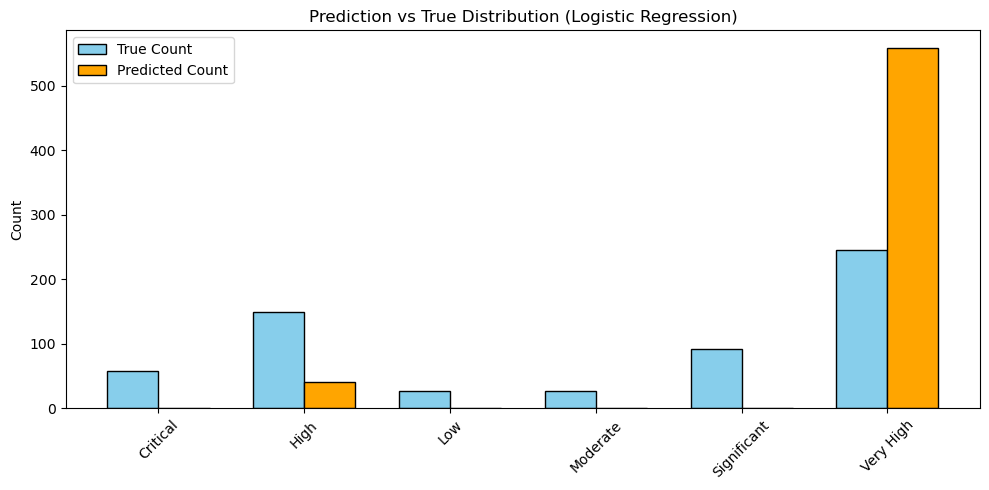

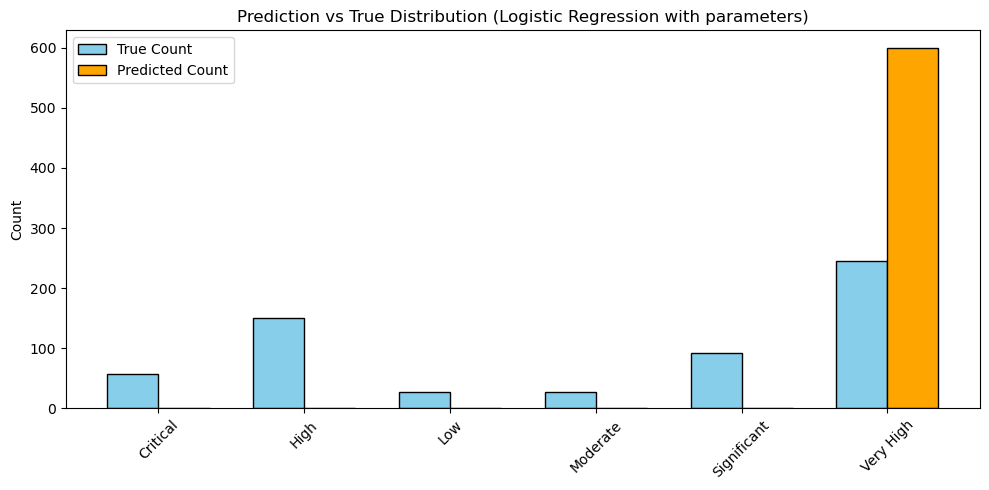

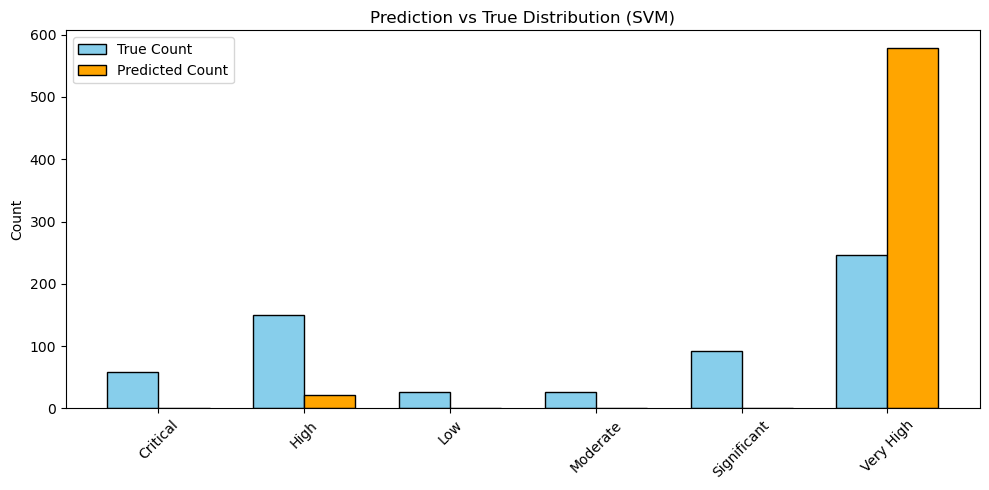

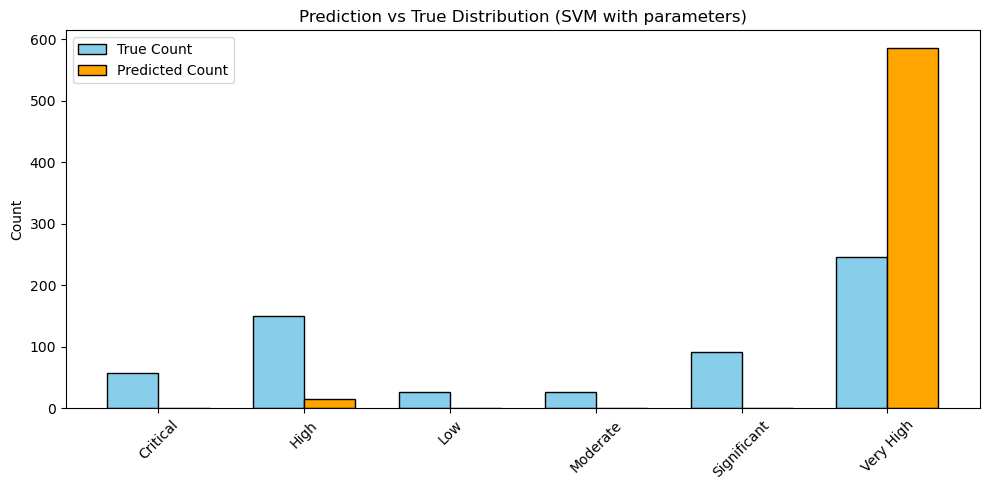

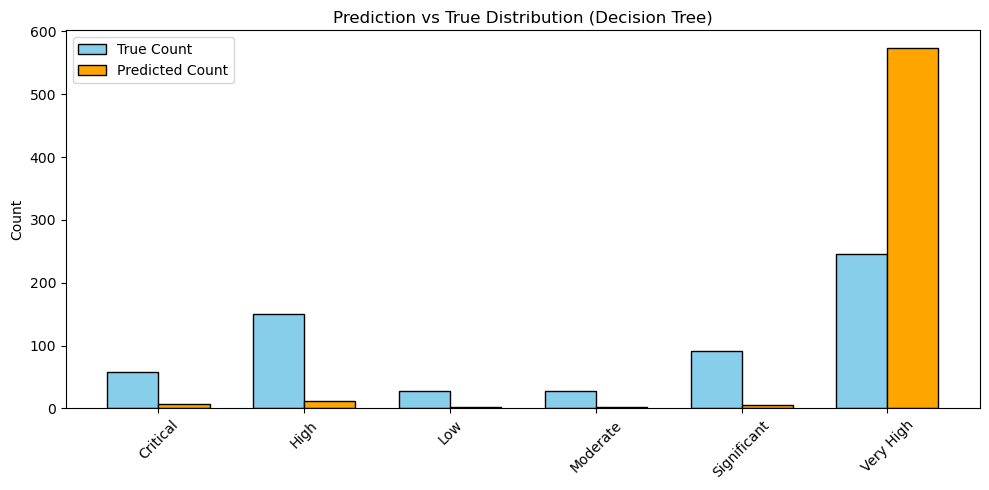

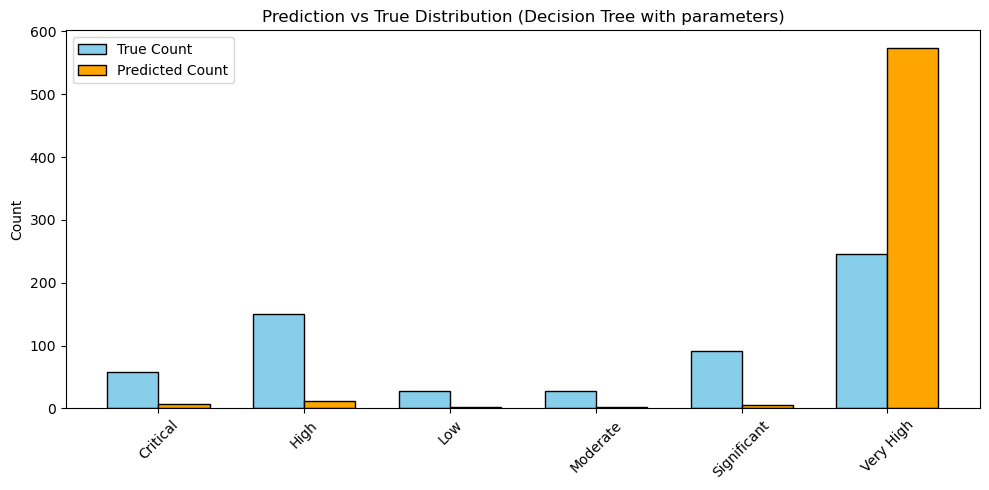

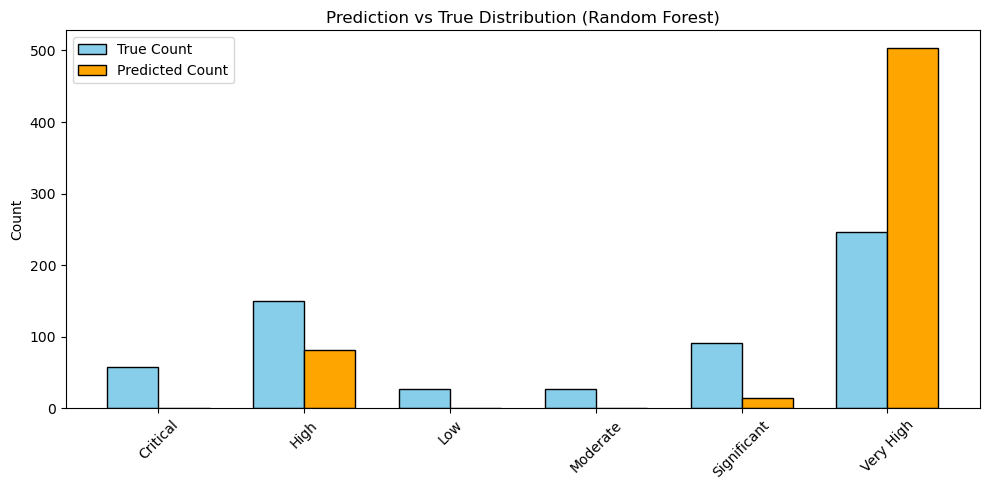

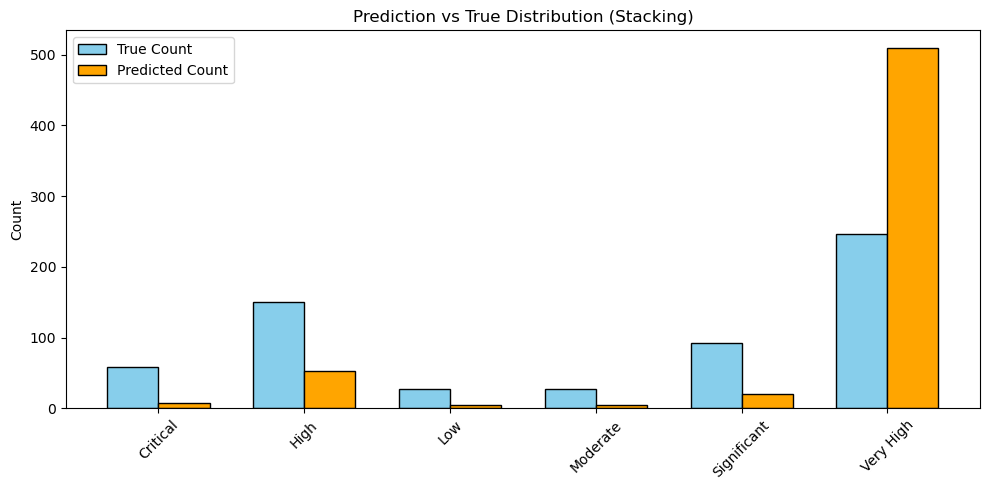

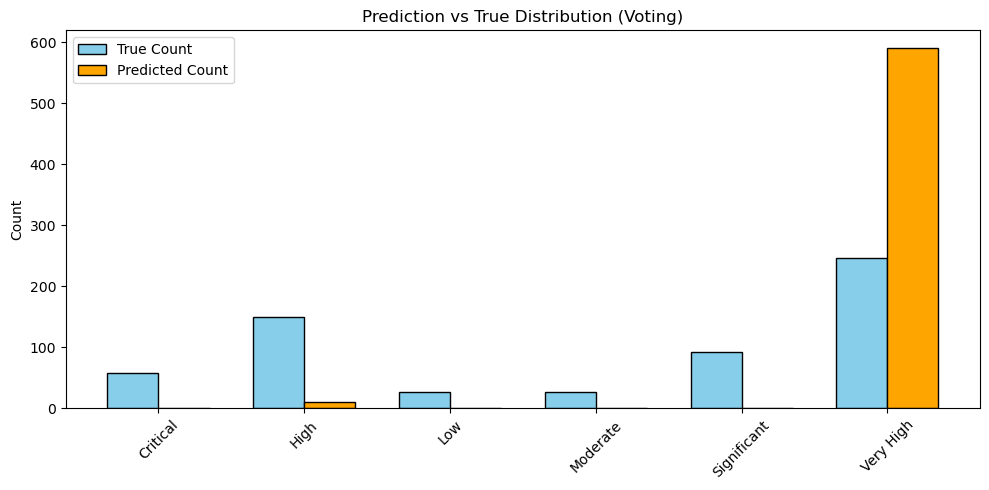

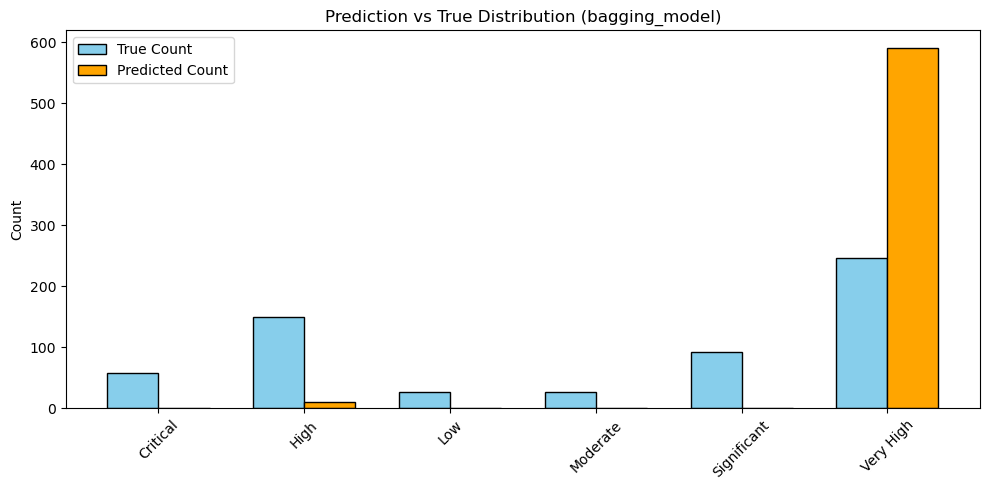

In [45]:
pred = logreg_model.predict(X_test)
plot_prediction_comparison(y_test, pred, "Prediction vs True Distribution (Logistic Regression)")

pred = best_logreg_model.predict(X_test)
plot_prediction_comparison(y_test, pred, "Prediction vs True Distribution (Logistic Regression with parameters)")

pred = svm_model.predict(X_test)
plot_prediction_comparison(y_test, pred, "Prediction vs True Distribution (SVM)")

pred = best_svm_model.predict(X_test)
plot_prediction_comparison(y_test, pred, "Prediction vs True Distribution (SVM with parameters)")

pred = dt_model.predict(X_test)
plot_prediction_comparison(y_test, pred, "Prediction vs True Distribution (Decision Tree)")

pred = dt_model.predict(X_test)
plot_prediction_comparison(y_test, pred, "Prediction vs True Distribution (Decision Tree with parameters)")

pred = rf_model.predict(X_test)
plot_prediction_comparison(y_test, pred, "Prediction vs True Distribution (Random Forest)")

pred = stacking_model.predict(X_test)
plot_prediction_comparison(y_test, pred, "Prediction vs True Distribution (Stacking)")

pred = voting_model.predict(X_test)
plot_prediction_comparison(y_test, pred, "Prediction vs True Distribution (Voting)")

pred = bagging_model.predict(X_test)
plot_prediction_comparison(y_test, pred, "Prediction vs True Distribution (Bagging)")

After testing a wide range of classification models including Logistic Regression, SVM, Decision Trees, Random Forests, Gradient Boosting, and several ensemble techniques, we observed that none of them exceeded an accuracy of about 40%. Even with hyperparameter tuning, dimensionality reduction, and extensive preprocessing, the models struggled to learn meaningful patterns. Our correlation analysis revealed that the dataset contains very weak relationships between the input variables and the financial loss category, meaning the features simply do not provide enough predictive information. As a result, the limited accuracy is not due to model choice but to the lack of correlated or informative variables in the dataset, making the prediction task inherently difficult.

With all of that, we can still try to predict the financial impact of an arriving attack.
Here's a fictional exemple:
- Country : USA
- Year : 2030
- Attack Type : Ransomware
- Target Industry : Banking
- Number of Affected Users : 500000
- Attack Source : External
- Security Vulnerability Type : Zero-Day
- Defense Mechanism Used : Firewall
- Inciden Resolution Time : 120h

We will predict financial loss category.

In [68]:
# New attack scenario
new_attack = pd.DataFrame([{
    "Country": "USA",
    "Year": 2030,
    "Attack Type": "Ransomware",
    "Target Industry": "Banking",
    "Number of Affected Users": 500000,
    "Attack Source": "External",
    "Security Vulnerability Type": "Zero-Day",
    "Defense Mechanism Used": "Firewall",
    "Incident Resolution Time (in Hours)": 120
}])


In [70]:
# Apply the best model
prediction = best_logreg_model.predict(new_attack)[0]
print("Predicted Loss Category:", prediction)

Predicted Loss Category: Very High


In [136]:
# for MLLP https://journals.plos.org/plosone/article?id=10.1371/journal.pone.0311041
# for Gradient Boost: https://arxiv.org/pdf/2410.05623